lori aznive berberian

last updated on november 29, 2025

## 1. Import necessary packages and functions from "kelp_ml_utils.py"

In [1]:

from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
plt.rcParams["figure.dpi"] = 110
from kelp_ml_utils import (make_supervised, train_test_split_time,make_ridge_model,run_ridge_all_stations,fit_ridge_for_series,rec_curve,)

## 2. Load in the remotel sensed kelp canopy area and biomass 
data hosted by the Santa Barbara Long Term Ecological Reserch and kelpwatch.org

In [2]:
kelp_nc = Path("Y:/personal/lberberian/Data/Alga/SBCLTER/LandsatKelpBiomass_2024_Q3_withmetadata.nc")
ds = xr.open_dataset(kelp_nc)

# set variables from 2d (time, station)
area = ds["area"]
time_index = ds["time"].to_index()
lat = ds["latitude"].values
lon = ds["longitude"].values
ntime, nstation = area.shape

print("number of time steps:", ntime)
print("number of stations (full domain):", nstation)
print("time range:", time_index[0], "→", time_index[-1])
print("full domain lat min/max:", float(lat.min()), float(lat.max()))
print("full domain lon min/max:", float(lon.min()), float(lon.max()))

# define cali only roi
is_ca = ((lat >= 32.0) & (lat <= 42.5) &(lon >= -125.5) & (lon <= -117.0))

# keep only stations that ever have kelp at least once
has_kelp = area.max(dim="time", skipna=True).values > 0

# combined mask
station_mask = is_ca & has_kelp
print("stations in ca box with kelp at least once:", int(station_mask.sum()))

# mask on station dimension to california
mask_da = xr.DataArray(
    station_mask,
    coords={"station": area["station"]},
    dims=["station"],
)

# cali only
area = area.where(mask_da, drop=True)
lat = lat[station_mask]
lon = lon[station_mask]
ntime, nstation = area.shape

print("CA-only area shape (time, station):", area.shape)
print("CA lat min/max:", float(lat.min()), float(lat.max()))
print("CA lon min/max:", float(lon.min()), float(lon.max()))
print("number of CA stations used:", nstation)


number of time steps: 163
number of stations (full domain): 585408
time range: 1984-02-15 00:00:00 → 2024-08-15 00:00:00
full domain lat min/max: 27.0087745595736 48.3952847530259
full domain lon min/max: -124.766643192559 -114.04202914419
stations in ca box with kelp at least once: 351859
CA-only area shape (time, station): (163, 351859)
CA lat min/max: 32.2542676241981 42.4981477504744
CA lon min/max: -124.500682128136 -117.001804849599
number of CA stations used: 351859


## 3. Build and state wide mean kelp canopy area time series and check out habitat map

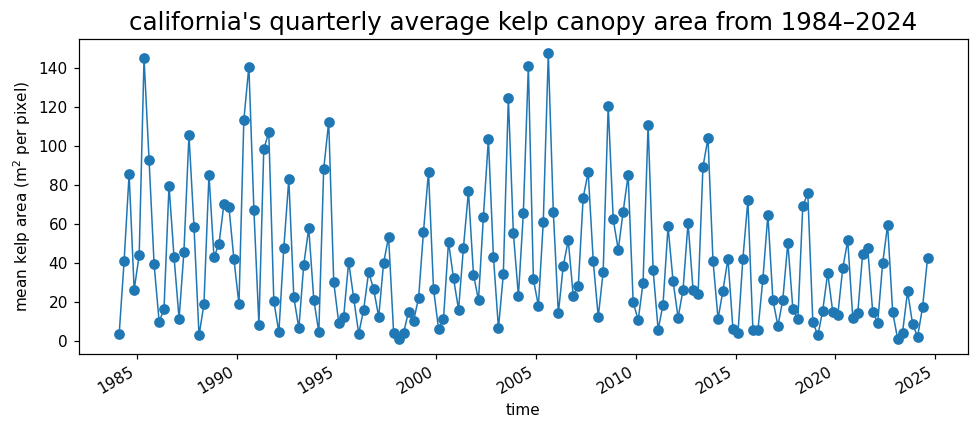

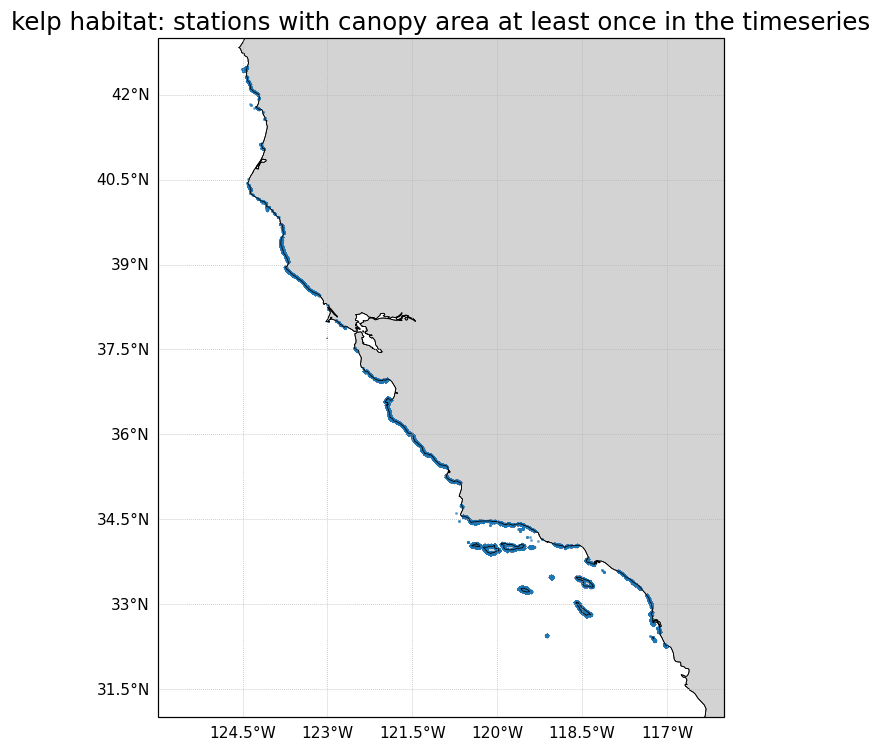

In [3]:
# statewide quarterly mean canopy
area_mean_ca = area.mean(dim="station", skipna=True).to_series().sort_index()
plt.figure(figsize=(9, 4))
area_mean_ca.plot(marker="o", linewidth=1)
plt.xlabel("time")
plt.ylabel("mean kelp area (m$^2$ per pixel)")
plt.title("california's quarterly average kelp canopy area from 1984–2024", fontsize=16)
plt.tight_layout()
plt.show()

# stations that have kelp at least once in the time series
vals = area.values  # main variables are : time, station
has_kelp_ts = np.nanmax(vals, axis=0) > 0
lon_kelp = lon[has_kelp_ts]
lat_kelp = lat[has_kelp_ts]

plt.figure(figsize=(6, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-126, -116, 31, 43], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, facecolor="lightgray", edgecolor="black", linewidth=0.5)
ax.coastlines(resolution="10m", linewidth=0.5)
ax.scatter(lon_kelp, lat_kelp, s=1, alpha=0.5, transform=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True, linewidth=0.5, linestyle=":")
gl.top_labels = False
gl.right_labels = False
ax.set_title("kelp habitat: stations with canopy area at least once in the timeseries", fontsize=16)
plt.tight_layout()
plt.show()

## 5. Check temporal autocorrelation for one station 
### remember that: 
- x-axis lag in quarters
    - lag = 0 means a time step with itself
    - lag = 1 means this quarter vs 1 quarter later
    - lag = 4 means this quarter vs 4 quarters later

- y-axis autocorrelation
    - values range from –1 to +1
    - +1: perfect positive correlation
    - 0: no linear relationship
    - –1: perfect negative correlation 

using station index: 64003
lat, lon: 36.221650381506 -121.773877546894


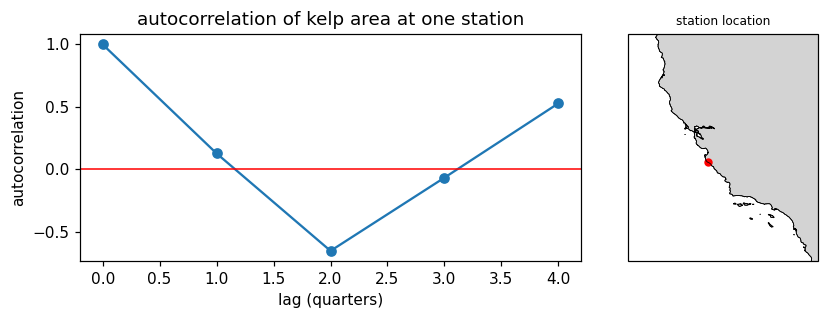

In [4]:
# pick station with largest mean kelp area
mean_area = area.mean(dim="time", skipna=True).values
station_idx = int(np.nanargmax(mean_area))
lat_pt = float(lat[station_idx])
lon_pt = float(lon[station_idx])

print("using station index:", station_idx)
print("lat, lon:", lat_pt, lon_pt)

series_kelp = area.isel(station=station_idx).to_series().sort_index().dropna()

# change the number of quarters to see how autocorrelation behaves
max_lag = 4  # number of quarters
lags = np.arange(max_lag + 1)
acf_vals = [series_kelp.autocorr(lag=k) for k in lags]

# set up figure
fig = plt.figure(figsize=(8, 3))
gs = fig.add_gridspec(1, 2, width_ratios=[2, 1])

# acf
ax_acf = fig.add_subplot(gs[0, 0])
ax_acf.plot(lags, acf_vals, marker="o", linestyle="-")
ax_acf.axhline(0, color="red", linewidth=1)
ax_acf.set_xlabel("lag (quarters)")
ax_acf.set_ylabel("autocorrelation")
ax_acf.set_title("autocorrelation of kelp area at one station")

# station location map
ax_map = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())

# california map
ax_map.set_extent([-126, -116, 31, 43], crs=ccrs.PlateCarree())
ax_map.add_feature(cfeature.LAND, facecolor="lightgray", edgecolor="black", linewidth=0.5)
ax_map.coastlines(resolution="10m", linewidth=0.5)

# station location
ax_map.scatter(lon_pt, lat_pt, s=20, color="red",marker="o",transform=ccrs.PlateCarree(),)

ax_map.set_title("station location", fontsize=8)
ax_map.tick_params(labelsize=6)
plt.tight_layout()
plt.show()

## 6. Run ridge regression over all stations with 1 year (4 quarters of history). Here we: 
- loop over every cali kelp pixel(station) in area 
- for each pixel, train a ridge regression model that uses the last 4 quarters of kelp area to predict the next quarter
- for each pixel, compare ridge to a naive baseline that just says next quarter = last quarter
- combines all pixels to compute the following:
    1. global RMSE for ridge vs naive
    2. statewide mean time series (true, ridge, naive, test quarters only)
    3. per-station metrics (RMSE, R², n_test)
    4. ridge coefficients per lag 

single-station test rmse: 221.0774085403435
single-station test R^2: 0.5834798254711562


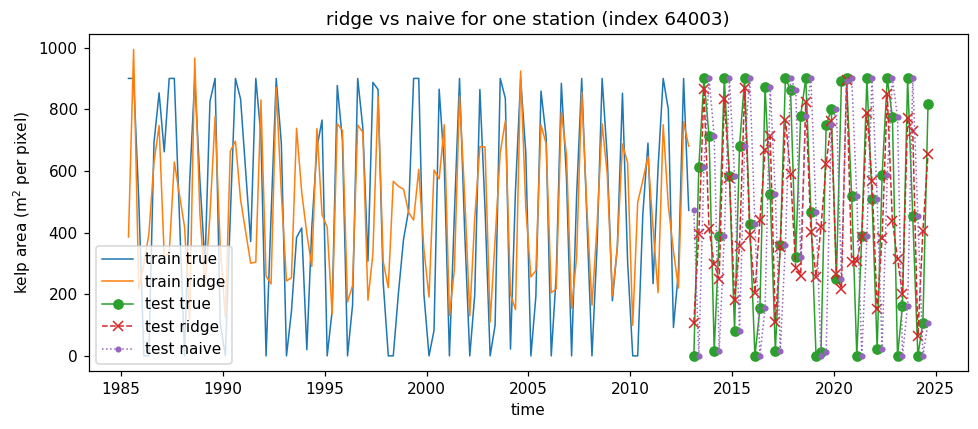

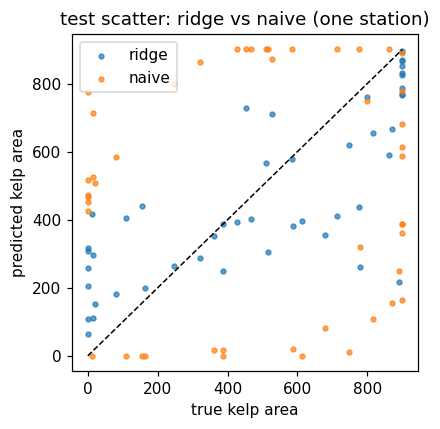

single-station min abs error (ridge): 1.4069099793257465 max: 671.9557200622112
single-station min abs error (naive): 10.0 max: 775.0


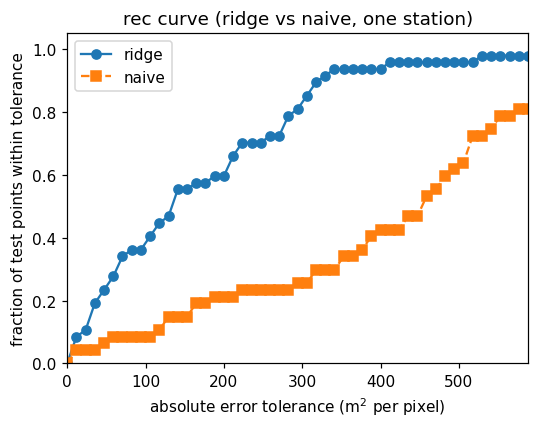

In [5]:

n_input = 4   # 4 quarters of history
train_frac = 0.7
alpha = 1.0

series_best = area.isel(station=station_idx).to_series().sort_index()

fit = fit_ridge_for_series(series_best,n_input=n_input, n_output=1, train_frac=train_frac,alpha=alpha,)
print("single-station test rmse:", fit["rmse_test"])
print("single-station test R^2:", fit["r2_test"])

# naive prediction for this station: copy last lag
y_naive_test = fit["x_test"][:, -1]

# time series of train and test
plt.figure(figsize=(9, 4))
plt.plot(fit["t_train"], fit["y_train"], label="train true", linewidth=1)
plt.plot(fit["t_train"], fit["y_pred_train"], label="train ridge", linewidth=1)

plt.plot(fit["t_test"], fit["y_test"], "o-", label="test true", linewidth=1)
plt.plot(fit["t_test"], fit["y_pred_test"], "x--", label="test ridge", linewidth=1)
plt.plot(fit["t_test"], y_naive_test, ".:", label="test naive", linewidth=1)

plt.xlabel("time")
plt.ylabel("kelp area (m$^2$ per pixel)")
plt.title(f"ridge vs naive for one station (index {station_idx})")
plt.legend()
plt.tight_layout()
plt.show()

# scatter plot of test true vs ridge and naive
plt.figure(figsize=(4, 4))
plt.scatter(fit["y_test"], fit["y_pred_test"], s=10, alpha=0.7, label="ridge")
plt.scatter(fit["y_test"], y_naive_test, s=10, alpha=0.7, label="naive")

min_val = min(fit["y_test"].min(), fit["y_pred_test"].min(), y_naive_test.min())
max_val = max(fit["y_test"].max(), fit["y_pred_test"].max(), y_naive_test.max())
plt.plot([min_val, max_val], [min_val, max_val], "k--", linewidth=1)

plt.xlabel("true kelp area")
plt.ylabel("predicted kelp area")
plt.title("test scatter: ridge vs naive (one station)")
plt.legend()
plt.tight_layout()
plt.show()

# rec curve for this station: ridge vs naive
abs_errors_ridge = np.abs(fit["y_test"] - fit["y_pred_test"])
abs_errors_naive = np.abs(fit["y_test"] - y_naive_test)

print("single-station min abs error (ridge):", float(abs_errors_ridge.min()),
      "max:", float(abs_errors_ridge.max()))
print("single-station min abs error (naive):", float(abs_errors_naive.min()),
      "max:", float(abs_errors_naive.max()))

max_tol = np.percentile(  np.concatenate([abs_errors_ridge, abs_errors_naive]), 90,)

tols_ridge, frac_ridge = rec_curve(fit["y_test"], fit["y_pred_test"], max_tol=max_tol)
tols_naive, frac_naive = rec_curve(fit["y_test"], y_naive_test, max_tol=max_tol)

plt.figure(figsize=(5, 4))
plt.plot(tols_ridge, frac_ridge, "o-", label="ridge")
plt.plot(tols_naive, frac_naive, "s--", label="naive")
plt.xlabel("absolute error tolerance (m$^2$ per pixel)")
plt.ylabel("fraction of test points within tolerance")
plt.title("rec curve (ridge vs naive, one station)")
plt.ylim(0, 1.05)
plt.xlim(0, max_tol)
plt.legend()
plt.tight_layout()
plt.show()

In [6]:
n_input = 4
train_frac = 0.7
alpha = 1.0

(rmse_ridge_global,rmse_naive_global,mean_true_ts,mean_pred_ts,mean_naive_ts,station_metrics, coefs,) = run_ridge_all_stations(area,time_index,n_input=n_input,n_output=1,train_frac=train_frac,alpha=alpha,return_coefs=True,)

print("global test performance (1-step ahead, 1-year history)")
print(f"ridge  rmse: {rmse_ridge_global:.2f}")
print(f"naive  rmse: {rmse_naive_global:.2f}")



fitting stations: 100%|███████████| 351859/351859 [31:18<00:00, 187.35it/s]


global test performance (1-step ahead, 1-year history)
ridge  rmse: 95.85
naive  rmse: 115.59


## 7. Statewide mean test set canopy area (true vs ridge vs naive)


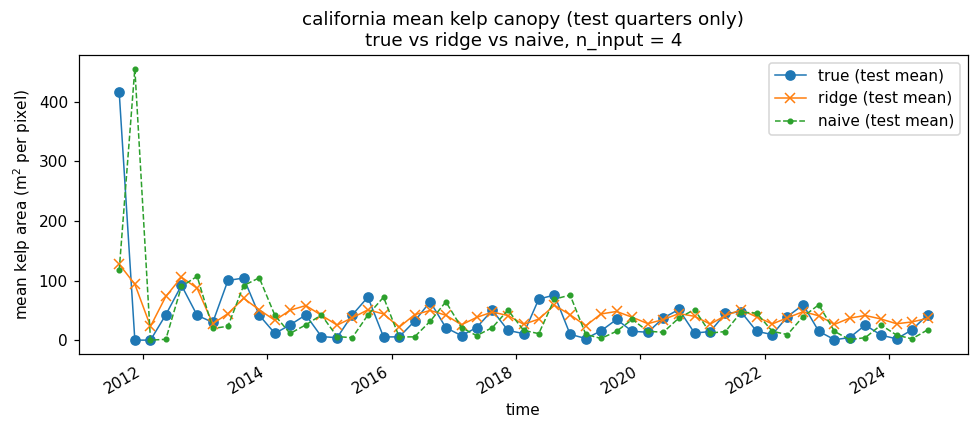

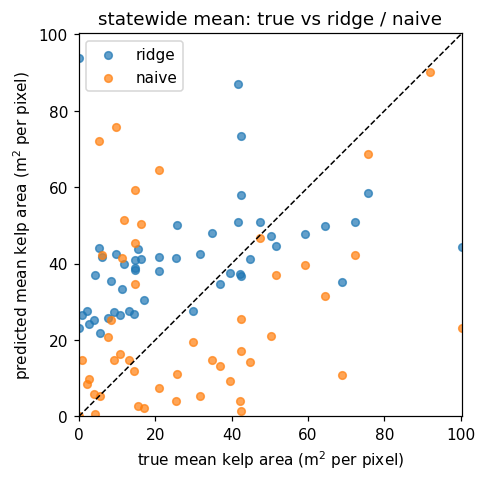

statewide mean abs error (ridge) min/max: 2.1020692395807146 289.5202746956243
statewide mean abs error (naive) min/max: 0.0 456.0


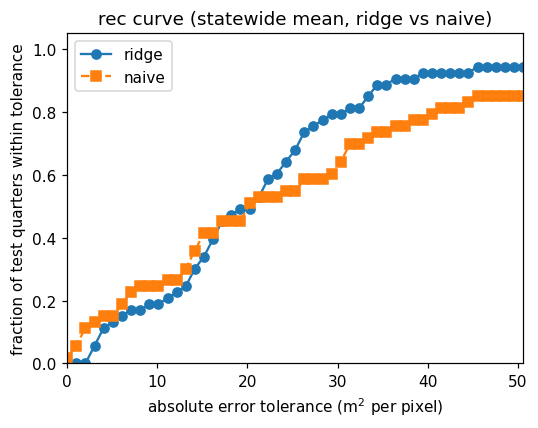

In [12]:
plt.figure(figsize=(9, 4))
mean_true_ts.plot(marker="o", linewidth=1, label="true (test mean)")
mean_pred_ts.plot(marker="x", linewidth=1, label="ridge (test mean)")
mean_naive_ts.plot(marker=".", linestyle="--", linewidth=1, label="naive (test mean)")

plt.xlabel("time")
plt.ylabel("mean kelp area (m$^2$ per pixel)")
plt.title(f"california mean kelp canopy (test quarters only)\ntrue vs ridge vs naive, n_input = {n_input}")
plt.legend()
plt.tight_layout()
plt.show()


# statewide mean: scatter of true vs ridge and naive
mask_ridge = np.isfinite(mean_true_ts.values) & np.isfinite(mean_pred_ts.values)
mask_naive = np.isfinite(mean_true_ts.values) & np.isfinite(mean_naive_ts.values)

true_mean   = mean_true_ts.values
ridge_mean  = mean_pred_ts.values
naive_mean  = mean_naive_ts.values

true_ridge = true_mean[mask_ridge]
ridge_vals = ridge_mean[mask_ridge]
true_naive = true_mean[mask_naive]
naive_vals = naive_mean[mask_naive]

# use percentiles to ignore extreme outliers when setting axes
all_vals = np.concatenate([true_ridge, ridge_vals, true_naive, naive_vals])
lo = 0.0  # or np.percentile(all_vals, 1)
hi = np.percentile(all_vals, 95)  # zoom into the main cluster

plt.figure(figsize=(4.5, 4.5))
plt.scatter(true_ridge, ridge_vals, s=25, alpha=0.7, label="ridge")
plt.scatter(true_naive, naive_vals, s=25, alpha=0.7, label="naive")

# 1:1 reference line over the zoomed range
plt.plot([lo, hi], [lo, hi], "k--", linewidth=1)

plt.xlim(lo, hi)
plt.ylim(lo, hi)
plt.gca().set_aspect("equal", adjustable="box")

plt.xlabel("true mean kelp area (m$^2$ per pixel)")
plt.ylabel("predicted mean kelp area (m$^2$ per pixel)")
plt.title("statewide mean: true vs ridge / naive")
plt.legend()
plt.tight_layout()
plt.show()

# statewide mean: rec curve for ridge vs naive
abs_err_ridge = np.abs(true_mean[mask_ridge] - ridge_mean[mask_ridge])
abs_err_naive = np.abs(true_mean[mask_naive] - naive_mean[mask_naive])

print("statewide mean abs error (ridge) min/max:",
      float(abs_err_ridge.min()), float(abs_err_ridge.max()))
print("statewide mean abs error (naive) min/max:",
      float(abs_err_naive.min()), float(abs_err_naive.max()))

# choose a shared max tolerance (e.g., 90th percentile of both)
all_errors = np.concatenate([abs_err_ridge, abs_err_naive])
max_tol = np.percentile(all_errors, 90)

tols_ridge, frac_ridge = rec_curve(true_mean[mask_ridge],
                                   ridge_mean[mask_ridge],
                                   max_tol=max_tol)
tols_naive, frac_naive = rec_curve(true_mean[mask_naive],
                                   naive_mean[mask_naive],
                                   max_tol=max_tol)

plt.figure(figsize=(5, 4))
plt.plot(tols_ridge, frac_ridge, "o-", label="ridge")
plt.plot(tols_naive, frac_naive, "s--", label="naive")
plt.xlabel("absolute error tolerance (m$^2$ per pixel)")
plt.ylabel("fraction of test quarters within tolerance")
plt.title("rec curve (statewide mean, ridge vs naive)")
plt.ylim(0, 1.05)
plt.xlim(0, max_tol)
plt.legend()
plt.tight_layout()
plt.show()


## 8. Map where the model works best (R² per station)

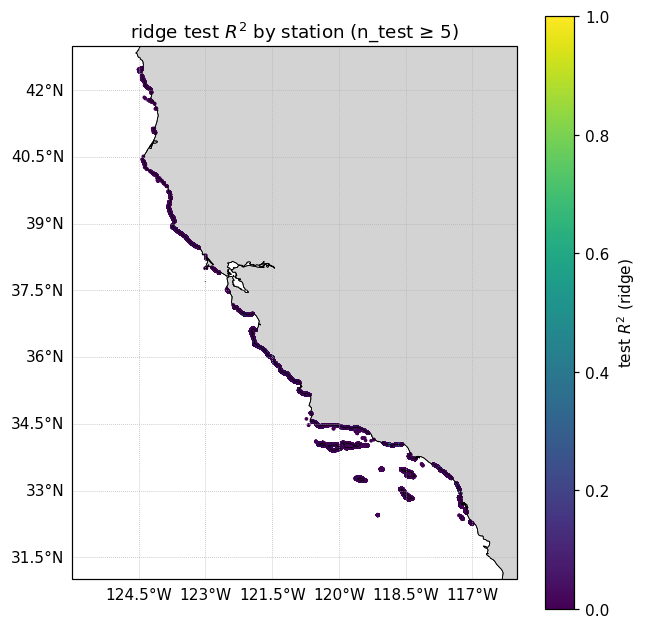

In [8]:
station_metrics["lat"] = lat
station_metrics["lon"] = lon
min_test = 5
good = station_metrics["n_test"] >= min_test

plt.figure(figsize=(6, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-126, -116, 31, 43], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, facecolor="lightgray", edgecolor="black", linewidth=0.5)
ax.coastlines(resolution="10m", linewidth=0.5)

sc = ax.scatter(station_metrics.loc[good, "lon"],station_metrics.loc[good, "lat"],c=station_metrics.loc[good, "r2_ridge"],s=2,cmap="viridis", vmin=0,vmax=1,transform=ccrs.PlateCarree(),)

gl = ax.gridlines(draw_labels=True, linewidth=0.5, linestyle=":")
gl.top_labels = False
gl.right_labels = False

plt.title("ridge test $R^2$ by station (n_test ≥ 5)")
cbar = plt.colorbar(sc, ax=ax, shrink=0.7)
cbar.set_label("test $R^2$ (ridge)")
plt.tight_layout()
plt.show()


## 9. Learned memory (lag weights)
this tells you, on average, how much the model leans on t-1 vs t-2 vs t-3 vs t-4 quarters. you can also slice coefs by latitude later to see if “memory” changes north–south.

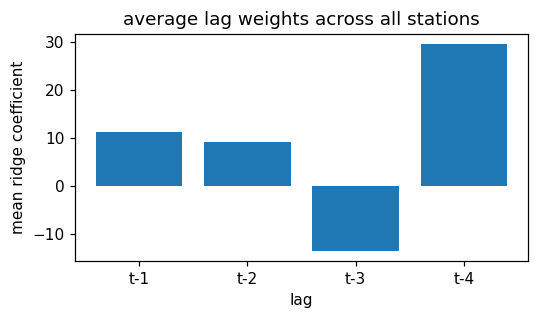

In [9]:

lag_labels = [f"t-{k}" for k in range(1, n_input + 1)]
mean_coefs = np.nanmean(coefs, axis=0)

plt.figure(figsize=(5, 3))
plt.bar(range(1, n_input + 1), mean_coefs)
plt.xticks(range(1, n_input + 1), lag_labels)
plt.xlabel("lag")
plt.ylabel("mean ridge coefficient")
plt.title("average lag weights across all stations")
plt.tight_layout()
plt.show()
